<left><img width=25% src="../slides/img/cornell_tech2.svg"></left>

# Lecture 15: Tree-Based Algorithms

In this lecture, we will cover a new class of supervised machine learning model, namely **tree-based** models, which can be used for both regression and classification tasks.

# 15.1. Decision Trees

We start by building some intuiton about decision trees and apply this algorithm to a familiar dataset we have already seen.

## 15.1.1. Intuition
Decision tress are machine learning models that mimic how a human would approach this problem.

1. We start by picking a feature (e.g., age)
2. Then we *branch* on the feature based on its value (e.g, age > 65?)
3. We select and branch on one or more features (e.g., is it a man?)
4. Then we return an output that depends on all the features we've seen (e.g., a man over 65)

## 15.1.2. Decision Trees: Example

Let's see an example on the diabetes dataset.

#### Review: Components of A Supervised Machine Learning Problem

Recall that a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

#### The UCI Diabetes Dataset

To explain what is a decision tree, we are going to use the UCI diabetes dataset that we have been working with earlier.

Let's start by loading this dataset and looking at some rows from the data.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True)
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [2]:
# Load the diabetes dataset
diabetes_X, diabetes_y = diabetes.data, diabetes.target

# create a binary risk feature
diabetes_y_risk = diabetes_y.copy()
diabetes_y_risk[:] = 0
diabetes_y_risk[diabetes_y > 150] = 1

# Print part of the dataset
diabetes_X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 15.1.2.1. Using `sklearn` to train a Decision Tree Classifer

We will train a decision tree using its implementation in `sklearn`.
We will import `DecisionTreeClassifier` from `sklearn`, fit it on the UCI Diabetes Dataset, and visualize the tree using the `plot_tree` function from `sklearn`.

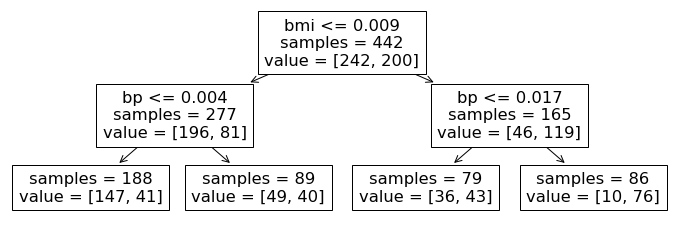

In [3]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# create and fit the model
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(diabetes_X.iloc[:,:4], diabetes_y_risk)

# visualize the model
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False);

Let's breakdown this visualization a bit more.
The visualied output above depicts the process by which our trained decision tree classifier makes predictions.
Each of the non-leaf nodes in this diagram corresponds to a decision that the algorithm makes based on the data or alternatively a rule that it applies.
Namely, for a new datapoint, starting at the root of this tree, the classifier looks at a specific feature  and asks whether the value for this feature is above or below some threshold.
If it is below, we proceed down the tree to the left, and if it is above, we proceed to the right.
We continue this process at each depth of the tree until we reach the ther leaf nodes (of which we have four in this example).

Let's follow these decisions down to one of the terminal leaf nodes to see how this works.
Starting at the top, the algorithm asks whether a patient has high or low `bmi` (defined by the threshold `0.009`).
For the **high** bmi patients, we proceed down the right and look at their blood pressure.
For patients with **high** blood pressure (values exceeding `0.017`), the algorithm has identified a 'high' risk sub-population of our dataset, as we see that 76 out the 86 patients that fall into this category have high risk of diabetes.

## 15.1.3. Decision Trees: Formal definition

Let's now define a decision tree a bit more formally.

### 15.1.3.1. Decision Rules

To do so, we introduce a core concept for decision trees, that of **decision rules**:
* A decision rule $r : \mathcal{X} \to \{\text{true}, \text{false}\}$ is a partition of the feature space into two disjoint regions, e.g.:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{bmi} \leq 0.009 \\ \text{false} & \text{if } x_\text{bmi} > 0.009 \end{cases} $$
* Normally, a rule applies to only one feature or attribute $x_j$ of $x$.
* If $x_j$ is continuous, the rule normally separates inputs $x_j$ into disjoint intervals ($-\infty, c], (c, \infty)$.

In theory, we could have more complex rules with multiple thresholds, but this would add unncessary complexity to the algorthim, since we can simply break rules with multiple thresholds into several sequential rules.

With this definition of decision rules, we can now more formally specify decision trees as (usually binary) trees, where: 

* Each internal node $n$ corresponds to a rule $r_n$
* The $j$-th edge out of $n$ is associated with a rule value $v_j$, and we follow the $j$-th edge if $r_n(x)=v_j$
* Each leaf node $l$ contains a prediction $f(l)$
* Given input $x$, we start at the root, apply its rule, follow the edge that corresponds to the outcome, and repeat recursively.

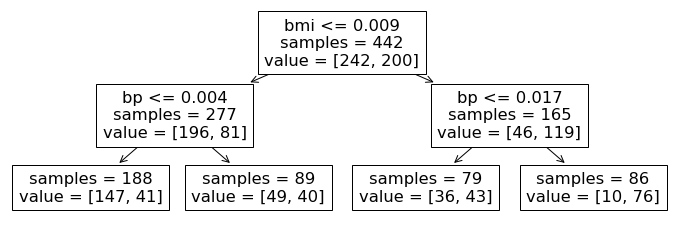

In [4]:
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False);

Returning to the visualization from our diabetes example, we have 3 internal nodes corresponding to the top two layers of the tree and four leaf nodes at the bottom of the tree.

### 15.1.3.2. Decision Regions

The next important concept in decision tress is that to **decision regions**.

Decision trees partition the space of features into regions:
* A decision region $R\subseteq \mathcal{X}$ is a subset of the feature space defined by the application of a set of rules $r_1, r_2, \ldots, r_m$ and their values $v_1, v_2, \ldots, v_m \in \{\text{true}, \text{false}\}$, i.e.:
$$ R = \{x \in \mathcal{X} \mid r_1(x) = v_1 \text{ and } \ldots \text{ and } r_m(x) = v_m \} $$
* For example, a decision region in the diabetes problem is:
$$ R = \{x \in \mathcal{X} \mid x_\text{bmi} \leq 0.009 \text{ and } x_\text{bp} > 0.004 \} $$

These regions correspond to the leaves of a decision tree.

We can illustrate decision regions via this figure from Hastie et al.

<center><img width=50% src="../slides/img/decision_tree.png"></center>

The illustrations are as follows:
* Top left: regions that cannot be represented by a tree
* Top right: regions that can be represented by a tree
* Bottom left: tree generating the top right regions
* Bottom right: function values assigned to the regions

### 15.1.3.3. Decision Trees

With the concept of regions, we can define a decision tree as a model $f : \mathcal{X} \to \mathcal{Y}$ of the form
$$ f(x) = \sum_{R \in \mathcal{R}} y_R \mathbb{I}\{x \in R\}. $$
* The $\mathbb{I}\{\cdot\}$ is an indicator function (one if $\{\cdot\}$ is true, else zero) and values $y_R \in \mathcal{Y}$ are the outputs for that region.
* The set $\mathcal{R}$ is a collection of decision regions. They are obtained by a recursive learning procedure (*recursive binary splitting*).
* The rules defining the regions $\mathcal{R}$ can be organized into a tree, with one rule per internal node and regions being the leaves.

## 15.1.4. Pros and Cons of Decision Trees

Decision trees are important models in machine learning
* They are highly interpretable.
* Require little data preparation (no rescaling, handle continuous and discrete features).
* Can be used for classification and regression equally well.

Their main disadvantages are that:
* If they stay small and interpretable, they are not as powerful.
* If they are large, they easily overfit and are hard to regularize.

# 15.2. Learning Decision Trees

We saw how decision trees are represented. How do we now learn them from data?



At a high level, decision trees are grown by adding nodes one at a time, as shown in the following pseudocode:

```python
def build_tree():
    whlie tree.is_complete() is False:
        leaf, leaf_data = tree.get_leaf()
        new_rule = create_rule(leaf_data)
        tree.append_rule(leaf, new_rule)
```

Most often, we build the tree until it reaches a maximum number of nodes. The crux of the algorithm is in `create_rule`.

## 15.2.1. Learning New Decision Rules

How does the `create_rule` function choose new rule $r$? Given a dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)}\mid i =1,2,\ldots,n\}$, we greedily choose the rule that minimizes a loss function.

This can be written as the following optimization problem:
$$ \min_{r \in \mathcal{U}} \left( \underbrace{L(\{(x, y) \in \mathcal{D} \mid r(x) = \text{T}\})}_\text{left subtree} +  \underbrace{L(\{(x, y) \in \mathcal{D} \mid r(x) = \text{F}\}}_\text{right subtree})\right) $$

where $L$ is a loss function over a subset of the data flagged by the rule, $\mathcal{U}$ is the set of possible rules, and T and F stand for 'True' and 'False,' respectively.

What is this set of possible rules $\mathcal{U}$?

When $x$ has continuous features, the rules have the following form:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_j \leq t \\ \text{false} & \text{if } x_j > t \end{cases} $$
for a feature index $j$ and threshold $t \in \mathbb{R}$.

When $x$ has categorial features, rules may have the following form:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_j = t_k \\ \text{false} & \text{if } x_j \neq t_k \end{cases} $$
for a feature index $j$ and possible value $t_k$ for $x_j$.

## 15.2.2. Objectives for Trees
What loss functions might we want to use when training a decision tree? 

### 15.2.2.1. Objectives for Trees: Regression

In regression, it is common to minimize the L2 error between the data and the single best prediction we can make on this data:
$$ L(\mathcal{D}) = \sum_{(x, y) \in \mathcal{D}} \left( y - \texttt{average-y}(\mathcal{D}) \right)^2. $$

If this was a leaf node, we would predict $\texttt{average-y}(\mathcal{D})$, the average $y$ in the data. The above loss measures the resulting squared error.

This results in the following optimization problem for selecting a decision rule:
$$ \min_{r \in \mathcal{U}} \sum_{(x, y) \in \mathcal{D} \,\mid\, r(x) = \text{true}} \left( y - p_\text{true}(r) \right)^2 +  \sum_{(x, y) \in \mathcal{D} \,\mid\, r(x) = \text{false}} \left( y - p_\text{false}(r) \right)^2 $$

where $p_\text{true}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D} \text{ and } r(x) = \text{true}\})$ and $p_\text{false}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D} \text{ and } r(x) = \text{false}\})$ are the average predictions on each part of the data split.

Notice that this loss incentivizes the algorithm to cluster together all the datapoints that have similar $y$ values into the same region.

### 15.2.2.2. Objectives for Trees: Classification

In classification, we use the misclassification rate
$$ L(\mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{(x, y) \in \mathcal{D}} \mathbb{I} \left\{ y \neq \texttt{most-common-y}(\mathcal{D}) \right\}. $$

If this was a leaf node, we would predict $\texttt{most-common-y}(\mathcal{D})$, the most common class $y$ in the data. The above loss measures the resulting misclassification error.

Again, notice that this loss incentivizes the algorithm to cluster together points that have similar class labels.

Other losses that can be used include the entropy or the gini index. These all optimize for a split in which different classes do not mix.

## 15.2.3. Other Practical Considerations

A few additional comments on the above training procedure:
* Nodes are added until the tree reaches a maximum depth or the leaves can't be split anymore.
* In practice, trees are also often pruned in order to reduce overfitting.
* There exist alternative algorithms, including ID3, C4.5, C5.0. See Hastie et al. for details.

## 15.2.4. Algorithm: Classification and Regression Trees (CART)

To summarize and combine our definition of trees from the section 16.1 with the optimization objective and procedure defined in this section, we have a decision tree algorithm that can be used for both classification and regression and is known as CART.

* __Type__: Supervised learning (regression and classification).
* __Model family__: Decision trees.
* __Objective function__: Squared error, mislcassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules, followed by pruning.

# 15.3. Bagging

Next, we are going to see a general technique to improve the performance of machine learning algorithms.

We will then apply it to decision trees to define an improved algorithm.

## 15.3.1. Overfitting and High-Variance

Recall that overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset and doesn't generalize.

To demonstrate overfitting, we return to a previous example, in which we take random samples around some 'true' function relationship $y = f(x).$

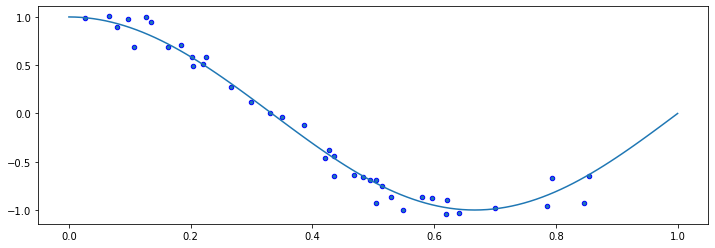

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fn(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(2)
n_samples = 40
X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples");

### 15.3.1.1. Fitting High-Degree Polynomials

Let's see what happens if we fit a high degree polynomial to random samples of 20 points from this dataset.
That is, we fit the same degree polynomial on different random draws of 20 points from our original dataset of 40 points and visualize the resulting trained polynomial model.

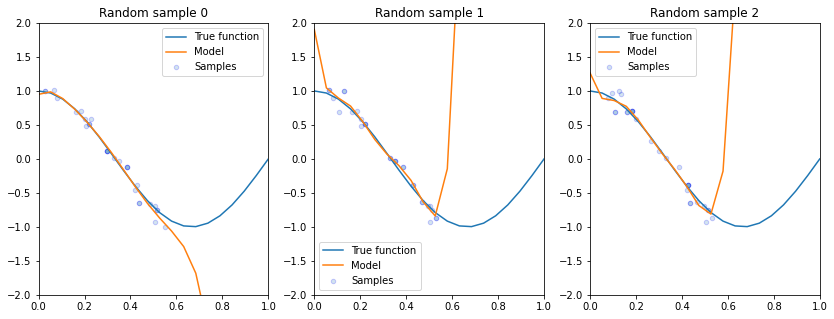

In [6]:
n_plots, X_line = 3, np.linspace(0,1,20)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, 30, size=(30,))
    X_random, y_random = X[random_idx], y[random_idx]

    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    ax.plot(X_line, true_fn(X_line), label="True function")    
    ax.plot(X_line, pipeline.predict(X_line[:, np.newaxis]), label="Model")
    ax.scatter(X_random, y_random, edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

Some things to notice from these plots:
* All of these models perform poorly on regions outside of data on which they were trained.
* Even though we trained the same class of model with the same hyperparameters on each of these subsampled datasets, we attain very different realizations of trained model for each subsample.

### 15.3.1.2 High-Variance Models

This phenomenon seen above is also known as the high-variance problem, which can be summarized as follows: Each small subset on which we train yields a very different model.

An algorithm that has a tendency to overfit is also called *high-variance*, because it outputs a predictive model that varies a lot if we slightly perturb the dataset.

## 15.3.2. Bagging: Bootstrap Aggregation

The idea of *bagging* is to reduce model variance by averaging many models trained on random subsets of the data.

The term 'bagging' stands for 'bootstrap aggregation.'
The data samples that are taken with replacement are known as bootstrap samples.

The idea of bagging is that the random errors of any given model trained on a specific bootstrapped sample, will 'cancel out' if we combine many models trained on different bootstrapped samples and average their outputs, which is known as ensembling in ML terminology.

In pseudocode, this can be performed as follows:

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(x_test)
```

## 15.3.3. Example: Bagged Polynomial Regression

Let's apply bagging to our polynomial regression problem.

We are going to train a large number of polynomial regressions on random subsets of the dataset of points that we created earlier.

We start by training an ensemble of bagged models, essentially implementing the pseudocode we saw above.

In [7]:
n_models, n_subset = 10000, 30
ensemble, Xs, ys = [], [], []
for i in range(n_models):
    # take a random subset of the data
    random_idx = np.random.randint(0, n_subset, size=(n_subset,))
    X_random, y_random = X[random_idx], y[random_idx]

    # train a polynomial regression model
    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    # add it to our set of bagged models
    ensemble += [pipeline]
    Xs += [X_random]
    ys += [y_random]

Let's visualize the prediction of the bagged model on each random dataset sample and compare to predictions from an un-bagged model.

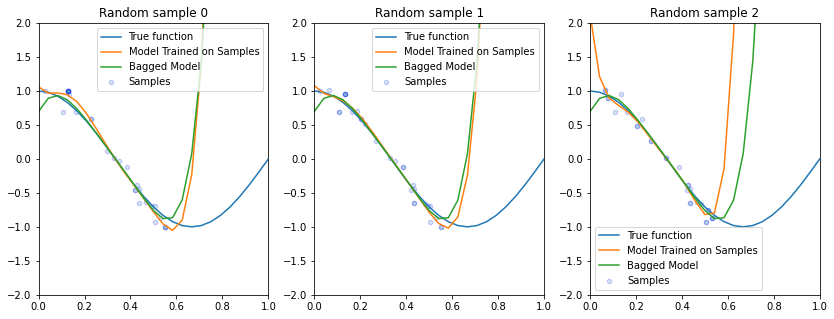

In [8]:
n_plots, X_line = 3, np.linspace(0,1,25)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)

    # generate average predictions
    y_lines = np.zeros((25, n_models))
    for j, model in enumerate(ensemble):
        y_lines[:, j] = model.predict(X_line[:, np.newaxis])
    y_line = y_lines.mean(axis=1)

    # visualize them
    ax.plot(X_line, true_fn(X_line), label="True function")    
    ax.plot(X_line, y_lines[:,i], label="Model Trained on Samples")
    ax.plot(X_line, y_line, label="Bagged Model")
    ax.scatter(Xs[i], ys[i], edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

Compared to the un-bagged model, we see that our bagged model varies less from one sample to the next and also better generalizes to unseen points in the sample.

## 15.3.4. Extensions of Bagging

There exist a few closely related techniques to bagging.
* Pasting is when samples are taken without replacement.
* Random features are when we randomly sample the features.
* Random patching is when we do both of the above.

## 15.3.5. Summary: Bagging

Bagging is a general technique that can be used with high-variance ML algorithms.

It averages predictions from multiple models trained on random subset of the data.

# 15.4. Random Forests

Next, let's see how bagging can be applied to decision trees. This will also provide us with a new algorithm.


## 15.4.1. Motivating Random Forests with Decision Trees
To motivate the random forests algorithm, we will see pitfalls of decision trees using the language of high-variance models that we just defined.

To distinguish random forests from decision trees, we will follow a running example.

#### Review: Iris Flowers Classification Dataset

We will re-use the Iris flowers dataset, which we have previously seen.

Recall, that this is a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936.
Nowadays, it's widely used for demonstrating machine learning algorithms.

In [9]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [10]:
# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


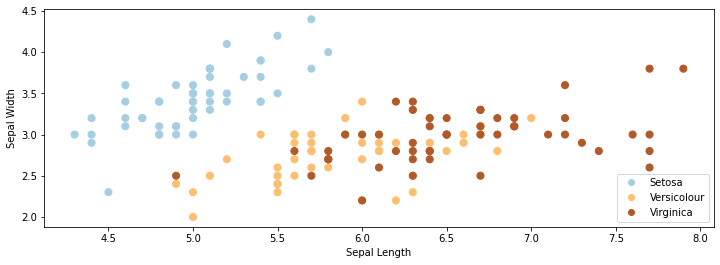

In [11]:
# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, s=50, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica', 'Query'],
           loc='lower right');

### 15.4.1. Decision Trees on the Flower Dataset

Let's now consider what happens when we train a decision tree on the Iris flower dataset.

The code below will be used to visualize predictions from decision trees on this dataset.

In [12]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

def make_grid(X):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    return xx, yy, x_min, x_max, y_min, y_max

def make_2d_preds(clf, X):
    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

def make_2d_plot(ax, Z, X, y):
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)

    # Put the result into a color plot
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=50)
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())    

We may now train and visualize a decision tree on this dataset.

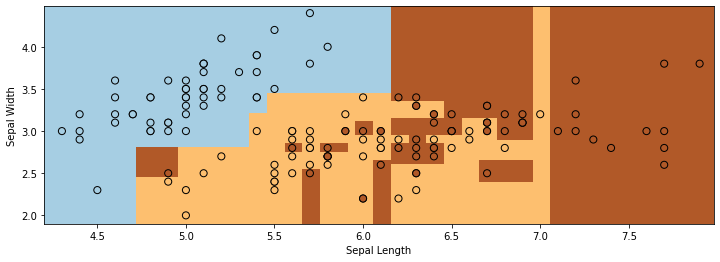

In [13]:
# Train a Decision Tree Model
ax = plt.gca()
X = iris_X.iloc[:,:2]
clf = DecisionTreeClassifier()
clf.fit(X, iris_y)
Z = make_2d_preds(clf, X)
make_2d_plot(ax, Z, X, iris_y)

### 15.4.1.1. Two Problems With Decision Trees

We see two problems with the output of the decision tree on the Iris dataset:
* The decision boundary between the two classes is very non-smooth and blocky.
* The decision tree overfits the data and the decision regions are highly fragmented.

### 15.4.1.2. High-Variance Decision Trees

When the trees have sufficiently large depth, they can quickly overfit the data.

Recall that this is called the *high-variance* problem, because small perturbations of the data lead to large changes in model predictions.

Consider the perofmrance of a decision tree classifier on 3 random subsets of the data.

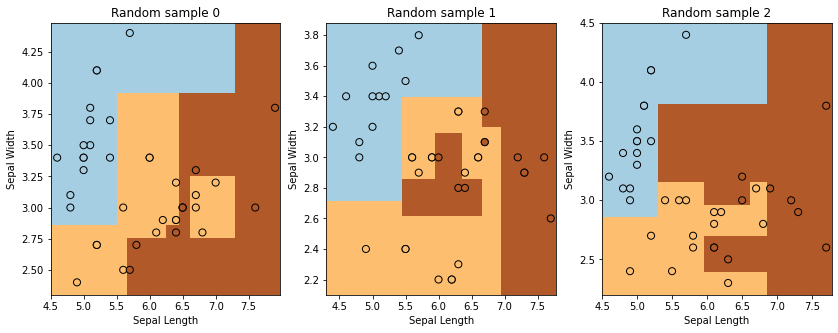

In [14]:
n_plots, n_flowers, n_samples = 3, iris_X.shape[0], 40
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, n_flowers, size=(n_samples,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    clf = DecisionTreeClassifier()
    clf.fit(X_random, y_random)
    Z = make_2d_preds(clf, X_random)
    make_2d_plot(ax, Z, X_random, y_random)
    ax.set_title('Random sample %d' % i)

## 15.4.2 Random Forests

In order to reduce the variance of the basic decision tree, we apply bagging -- the variance reduction technique that we have seen earlier.

We refer to bagged decision trees as *Random Forests*.

Instantiating our definition of bagging with decision trees, we obtain the following pseudocode defintion of random forests:

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = DecisionTree().fit(X_i, y_i)
    random_forest.append(model)

# output average prediction at test time:
y_test = random_forest.average_prediction(y_test)
```

We may implement random forests in python as follows:

In [15]:
np.random.seed(1000)
n_models, n_flowers, n_subset = 300, iris_X.shape[0], 10
random_forest = []
for i in range(n_models):
    # sample the data with replacement
    random_idx = np.random.randint(0, n_flowers, size=(n_subset,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    # train a decision tree model
    clf = DecisionTreeClassifier()
    clf.fit(X_random, y_random)

    # append it to our ensemble
    random_forest += [clf]

### 15.4.2.1 Random Forests on the Flower Dataset

Consider now what happens when we deploy random forests on the same dataset as before.

Now, each prediction is the average on the set of bagged decision trees.

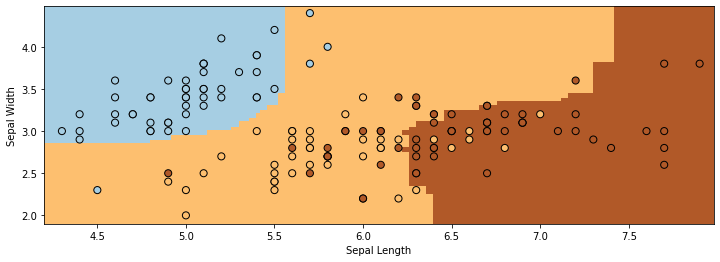

In [16]:
# Visualize predictions from a random forest
ax = plt.gca()

# compute average predictions from all the models in the ensemble
X_all, y_all = iris_X.iloc[:,:2], iris_y
Z_list = []
for clf in random_forest:
    Z_clf = make_2d_preds(clf, X_all)
    Z_list += [Z_clf]
Z_avg = np.stack(Z_list, axis=2).mean(axis=2)

# visualize predictions
make_2d_plot(ax, np.rint(Z_avg), X_all, y_all)

The boundaries are much more smooth and well-behaved compared to those we saw for decision trees.
We also clearly see less overfitting.

## 15.4.3 Algorithm: Random Forests

Summarizing random forests, we have:

* __Type__: Supervised learning (regression and classification).
* __Model family__: Bagged decision trees.
* __Objective function__: Squared error, mislcassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules, followed by pruning.

## 15.4.4 Pros and Cons of Random Forests

Random forests remain a popular machine learning algorithm:
* As with decision trees, they require little data preparation (no rescaling, handle continuous and discrete features, work well for classification and regression).
* They are often quite accurate.

Their main disadvantages are that:
* They are not interpretable due to bagging (unlike decision trees).
* They do not work with unstructured data (images, audio).